In [8]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import utils
import khammash_repro

In [9]:
# Load Training Data

path = "/home/smalani/controlledLearning/training_data"
training_L = np.load(path + "/training_L.npy")
training_sp = np.load(path + "/training_sp.npy")
training_t = np.load(path + "/training_t.npy")
training_y = np.load(path + "/training_y.npy")

In [13]:
# Define Dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, training_t, training_y, training_L, time_forecast=1):
        t0, t1, L0, L1, y0, y1 = self.split_data(training_t, training_L, training_y, time_forecast)
        self.t0 = t0
        self.t1 = t1
        self.L0 = L0
        self.L1 = L1
        self.y0 = y0
        self.y1 = y1

    def split_data(self, t, L, y, time_forecast):
        total_time_length = t.shape[1]

        t0, t1, L0, L1, y0, y1 = [], [], [], [], [], []

        for j in range(t.shape[0]):
            for i in range(total_time_length - time_forecast):
                t0.append(t[j, i])
                y0.append(y[j, i])

                t1_add, L0_add, L1_add, y1_add = [], [], [], []
                for k in range(time_forecast):
                    t1_add.append(t[j, i + k+1])
                    L0_add.append(L[j, i + k])
                    L1_add.append(L[j, i + k+1])
                    y1_add.append(y[j, i + k+1])

                t1.append(t1_add)
                L1.append(L1_add)
                L0.append(L0_add)
                y1.append(y1_add)


        t0 = np.array(t0)
        t1 = np.array(t1)
        L0 = np.array(L0)
        L1 = np.array(L1)
        y0 = np.array(y0)
        y1 = np.array(y1)

        return t0, t1, L0, L1, y0, y1
    
    # def make_minmax_scaler(self, x):
    #     min_val = np.min(x)
    #     max_val = np.max(x)
    #     setattr(self.x, "min_val", min_val)
    #     setattr(self.x, "max_val", max_val)
    
    # def minmax_scale(self, x):
    #     min_val = getattr(self.x, "min_val", None)
    #     max_val = getattr(self.x, "max_val", None)
    #     return (x - min_val) / (max_val - min_val)
    
    # def minmax_unscale(self, x):
    #     min_val = getattr(self.x, "min_val", None)
    #     max_val = getattr(self.x, "max_val", None)
    #     return x * (max_val - min_val) + min_val

    def __len__(self):
        return self.t0.shape[0]

    def __getitem__(self, idx):
        t0 = torch.tensor(self.t0[idx]).unsqueeze(0)
        t1 = torch.tensor(self.t1[idx])#.unsqueeze(0)
        L0 = torch.tensor(self.L0[idx])#.unsqueeze(0)
        L1 = torch.tensor(self.L1[idx]).unsqueeze(0)
        y0 = torch.tensor(self.y0[idx])
        y1 = torch.tensor(self.y1[idx])

        return t0, t1, L0, L1, y0, y1

In [14]:
# Define the model
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device, max_step):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)

        self.input_scale = torch.tensor([1000, 100, 100, 1, 800]).unsqueeze(0).to(device)
        self.ode_scale = torch.tensor([100, 100, 100, 1]).unsqueeze(0).to(device)

        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        self.device = device
        self.max_step = max_step

    def network(self, y0, L0):
        x = torch.cat((y0, L0), dim=1) / self.input_scale
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x
    
    def ODEs(self, y0, L0):
        dydt = self.network(y0, L0) * self.ode_scale

        return dydt
    
    def RK4(self, y0, L0, dt):
        k1 = self.ODEs(y0, L0)
        k2 = self.ODEs(y0 + dt/2 * k1, L0)
        k3 = self.ODEs(y0 + dt/2 * k2, L0)
        k4 = self.ODEs(y0 + dt * k3, L0)

        y1 = y0 + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

        return y1

    def move_to_device(self, t0, t1, L0, y0):
        t0 = t0.to(self.device)
        t1 = t1.to(self.device)
        L0 = L0.to(self.device)
        y0 = y0.to(self.device)

        return t0, t1, L0, y0
    
    def forward(self, t0, t1, L0, y0):
        t0, t1, L0, y0 = self.move_to_device(t0, t1, L0, y0)
        past_time = t0[:, [0]]
        y_out = []
        for i in range(t1.shape[1]):
            dt = t1[:, [i]] - past_time
            past_time = t1[:, [i]]
            dt_split = torch.rand(dt.shape).to(self.device)
            dt1 = dt * dt_split
            dt2 = dt - dt1

            L_in = L0[:, [i]]

            y0 = self.RK4(y0, L_in, dt1)
            y0 = self.RK4(y0, L_in, dt2)
            y_out.append(y0)
        y_out = torch.stack(y_out, dim=1)
        return y_out
    
    def forward_backup(self, t0, t1, L0, y0):
        t0, t1, L0, y0 = self.move_to_device(t0, t1, L0, y0)

        dt = t1 - t0
        dt_split = torch.rand(dt.shape).to(self.device)
        dt1 = dt * dt_split
        dt2 = dt - dt1

        y_int = self.RK4(y0, L0, dt1)
        y_pred = self.RK4(y_int, L0, dt2)

        return y_pred
    
    def forward_backup2(self, t0, t1, L0, y0):
        t0, t1, L0, y0 = self.move_to_device(t0, t1, L0, y0)

        dt = t1 - t0
        t_tot = 0
        dt_arr = []
        while t_tot < torch.min(dt):
            t_append = torch.min(torch.ones_like(dt)*self.max_step, dt - t_tot)
            dt_arr.append(t_append)
            t_tot += self.max_step
        dt_arr = torch.cat(dt_arr, dim=1)
        dt_arr = dt_arr[:,np.random.permutation(dt_arr.shape[1])]
        dt_arr = torch.tensor(dt_arr).to(self.device)

        for i in range(dt_arr.shape[1]):
            y0 = self.RK4(y0, L0, dt_arr[:,[i]])

        return y0

In [15]:
# Create Dataset
time_forecast = 10
dataset = Dataset(training_t, training_y, training_L, time_forecast=time_forecast)

# Min/Max Normalization


# Train Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define the dataloader
batch_size = 10000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model
input_size = 5
hidden_size = 64
output_size = 4

max_step = 0.04384

model = Model(input_size, hidden_size, output_size, device, max_step).to(device).to(torch.float64)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= 1e-2)

# Define the lr scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-6)

In [16]:
# Define the training loop

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    model.train()
    for batch, (t0, t1, L0, L1, y0, y1) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(t0, t1, L0, y0)

        # Scale the predictions
        y1 = y1.to(device) / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)
        pred = pred / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)

        loss = loss_fn(pred, y1)
        # assert False

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(t0)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    lr_scheduler.step(train_loss)

    lr = optimizer.param_groups[0]['lr']

    return train_loss , lr


def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for t0, t1, L0, L1, y0, y1 in dataloader:
            pred = model(t0, t1, L0, y0)

            # Scale the predictions
            y1 = y1.to(device) / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)
            pred = pred / (torch.tensor([2000,300,500,1])).to(device).unsqueeze(0)
            
            val_loss += loss_fn(pred, y1).item()
    
    return val_loss 

In [17]:
# Train the model
epochs = 2000
train_loss_list = []
val_loss_list = []
lr_list = []

pbar = tqdm(range(epochs))

for t in pbar:
    train_loss, lr = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, model, loss_fn)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    lr_list.append(lr)

    pbar.set_description(f"Epoch {t+1}")
    pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, lr=lr)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 00993: reducing learning rate of group 0 to 5.0000e-03.


Text(0.5, 1.0, 'Loss vs Epochs')

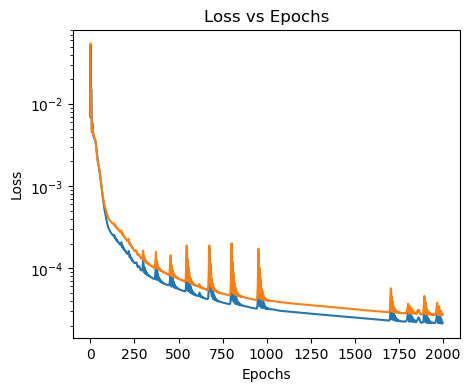

In [18]:
# Plot the loss

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.semilogy(train_loss_list, label='Train Loss')
ax.semilogy(val_loss_list, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Epochs')

In [20]:
dataset.L0.shape

(2682, 10)

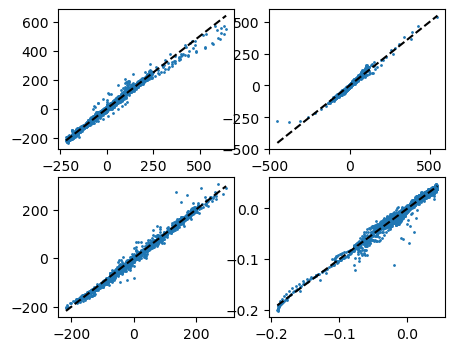

In [21]:
#  Performance on training data

def learned_model_ode(t, y0, L0):
    L0 = torch.tensor(L0).to(device)
    y0 = torch.tensor(y0).to(device)
    if len(y0.shape) == 1:
        y0 = y0.unsqueeze(0)
    while len(y0.shape) > len(L0.shape):
        L0 = L0.unsqueeze(-1)
    dydt = model.ODEs(y0, L0)

    return dydt.cpu().detach().numpy().squeeze()
    

true_dydt = khammash_repro.ode_fun(0, dataset.y0.T, dataset.L0[:,0]).T * 60
learned_dydt = learned_model_ode(0, dataset.y0, dataset.L0[:,0])

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(221)
ax.scatter(true_dydt[:,0], learned_dydt[:,0], s=1)
ax.plot([np.min(true_dydt[:,0]), np.max(true_dydt[:,0])], [np.min(true_dydt[:,0]), np.max(true_dydt[:,0])], 'k--')

ax = fig.add_subplot(222)
ax.scatter(true_dydt[:,1], learned_dydt[:,1], s=1)
ax.plot([np.min(true_dydt[:,1]), np.max(true_dydt[:,1])], [np.min(true_dydt[:,1]), np.max(true_dydt[:,1])], 'k--')

ax = fig.add_subplot(223)
ax.scatter(true_dydt[:,2], learned_dydt[:,2], s=1)
ax.plot([np.min(true_dydt[:,2]), np.max(true_dydt[:,2])], [np.min(true_dydt[:,2]), np.max(true_dydt[:,2])], 'k--')

ax = fig.add_subplot(224)
ax.scatter(true_dydt[:,3], learned_dydt[:,3], s=1)
ax.plot([np.min(true_dydt[:,3]), np.max(true_dydt[:,3])], [np.min(true_dydt[:,3]), np.max(true_dydt[:,3])], 'k--')


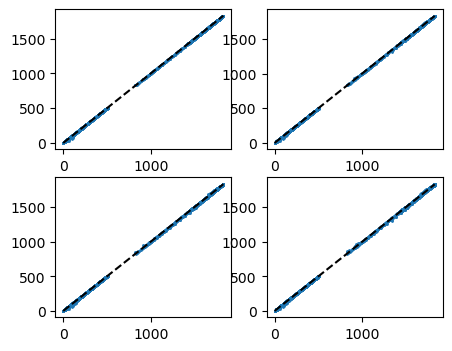

In [23]:
t0 = torch.tensor(dataset.t0).to(device).unsqueeze(-1)
t1 = torch.tensor(dataset.t1).to(device)#.unsqueeze(-1)
L0 = torch.tensor(dataset.L0).to(device)#.unsqueeze(-1)
y0 = torch.tensor(dataset.y0).to(device)

y1_pred = model.forward(t0, t1, L0, y0).cpu().detach().numpy()

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(221)
ax.scatter(dataset.y1[:,0], y1_pred[:,0], s=1)
ax.plot([np.min([dataset.y1[:,0]]), np.max([dataset.y1[:,0]])], [np.min([dataset.y1[:,0]]), np.max([dataset.y1[:,0]])], 'k--')

ax = fig.add_subplot(222)
ax.scatter(dataset.y1[:,1], y1_pred[:,1], s=1)
ax.plot([np.min([dataset.y1[:,1]]), np.max([dataset.y1[:,1]])], [np.min([dataset.y1[:,1]]), np.max([dataset.y1[:,1]])], 'k--')

ax = fig.add_subplot(223)
ax.scatter(dataset.y1[:,2], y1_pred[:,2], s=1)
ax.plot([np.min([dataset.y1[:,2]]), np.max([dataset.y1[:,2]])], [np.min([dataset.y1[:,2]]), np.max([dataset.y1[:,2]])], 'k--')

ax = fig.add_subplot(224)
ax.scatter(dataset.y1[:,3], y1_pred[:,3], s=1)
ax.plot([np.min([dataset.y1[:,3]]), np.max([dataset.y1[:,3]])], [np.min([dataset.y1[:,3]]), np.max([dataset.y1[:,3]])], 'k--')


In [24]:
y1_pred.shape

(2682, 10, 4)